# DataFrames: Groupby

This notebook uses the Pandas groupby-aggregate and groupby-apply on scalable Dask dataframes.  It will discuss both common use and best practices.

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [1]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='2GB')
client

<Client: 'inproc://10.1.0.4/7858/1' processes=1 threads=4, memory=2.00 GB>

## Artifical dataset

We create an artificial timeseries dataset to help us work with groupby operations

In [2]:
import dask
df = dask.datasets.timeseries()
df

Dask DataFrame Structure:
                   id    name        x        y
npartitions=30                                 
2000-01-01      int64  object  float64  float64
2000-01-02        ...     ...      ...      ...
...               ...     ...      ...      ...
2000-01-30        ...     ...      ...      ...
2000-01-31        ...     ...      ...      ...
Dask Name: make-timeseries, 30 tasks

This dataset is small enough to fit in the cluster's memory, so we persist it now.

You would skip this step if your dataset becomes too large to fit into memory.

In [3]:
df = df.persist()

## Groupby Aggregations

Dask dataframes implement a commonly used subset of the Pandas groupby API (see [Pandas Groupby Documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

We start with groupby aggregations.  These are generally fairly efficient, assuming that the number of groups is small (less than a million).

In [4]:
df.groupby('name').x.mean().compute()

name
Alice      -0.001229
Bob        -0.000458
Charlie     0.001485
Dan         0.001159
Edith      -0.002212
Frank      -0.002319
George      0.000495
Hannah     -0.002474
Ingrid      0.003792
Jerry      -0.003960
Kevin       0.000210
Laura       0.002336
Michael     0.001108
Norbert     0.001853
Oliver      0.000179
Patricia    0.000331
Quinn      -0.003968
Ray        -0.001666
Sarah      -0.001982
Tim        -0.002565
Ursula     -0.002584
Victor      0.004200
Wendy       0.001982
Xavier      0.001326
Yvonne      0.002108
Zelda       0.003201
Name: x, dtype: float64

Performance will depend on the aggregation you do (mean vs std), the key on which you group (name vs id), and the number of total groups

In [5]:
%time _ = df.groupby('id').x.mean().compute()

CPU times: user 207 ms, sys: 4.16 ms, total: 211 ms
Wall time: 193 ms


In [6]:
%time _ = df.groupby('name').x.mean().compute()

CPU times: user 487 ms, sys: 26.2 ms, total: 513 ms
Wall time: 443 ms


In [7]:
%time df.groupby('name').agg({'x': ['mean', 'std'], 'y': ['mean', 'count']}).compute().head()

CPU times: user 435 ms, sys: 24.2 ms, total: 460 ms
Wall time: 427 ms


x                   y        
             mean       std      mean   count
name                                         
Alice   -0.001229  0.577442 -0.000889  100148
Bob     -0.000458  0.577175 -0.001145   99713
Charlie  0.001485  0.577522  0.000195   99533
Dan      0.001159  0.577574  0.000396  100234
Edith   -0.002212  0.577309  0.001842   99946

This is the same as with Pandas.  Generally speaking, Dask.dataframe groupby-aggregations are roughly same performance as Pandas groupby-aggregations, just more scalable.

You can read more about Pandas' common aggregations in [the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html#aggregation).



## Custom Aggregations

Dask dataframe Aggregate is available for custom aggregations (See [Dask dataframe Aggregate Documentation](https://docs.dask.org/en/latest/dataframe-groupby.html#aggregate))

## Many groups

By default groupby-aggregations (like groupby-mean or groupby-sum) return the result as a single-partition Dask dataframe.  Their results are *usually* quite small, so this is *usually* a good choice.

However, sometimes people want to do groupby aggregations on *many* groups (millions or more).  In these cases the full result may not fit into a single Pandas dataframe output, and you may need to split your output into multiple partitions.  You can control this with the `split_out=` parameter

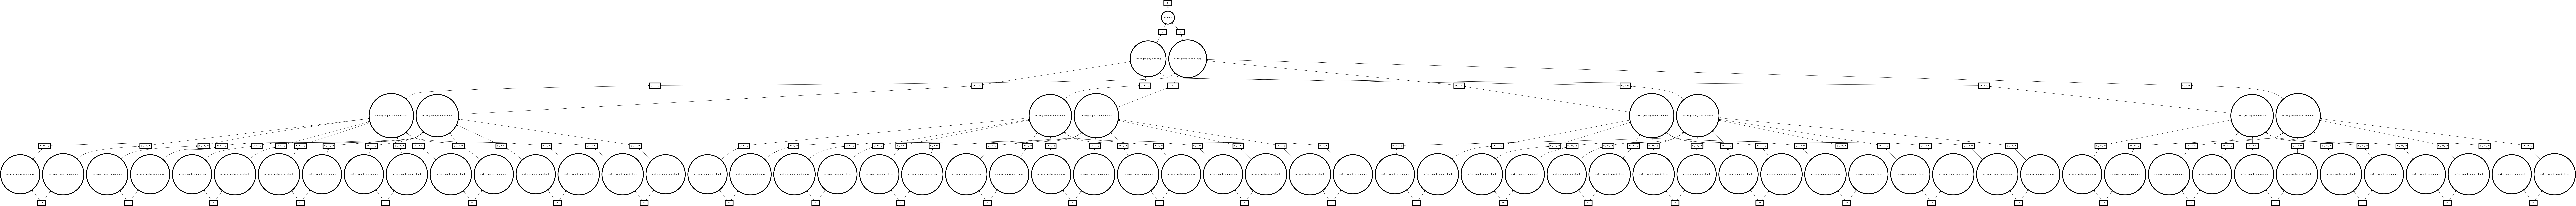

In [8]:
# Computational graph of a single output aggregation (for a small number of groups, like 1000)
df.groupby('name').x.mean().visualize(node_attr={'penwidth': '6'})

In [9]:
# Computational graph of an aggregation to four outputs (for a larger number of groups, like 1000000)
df.groupby('id').x.mean(split_out=4).visualize(node_attr={'penwidth': '6'})

## Groupby Apply

Groupby-aggregations are generally quite fast because they can be broken down easily into well known operations.  The data doesn't have to move around too much and we can just pass around small intermediate values across the network.

For some operations however the function to be applied requires *all* data from a given group (like every record of someone named "Alice").  This will force a great deal of communication and be more expensive, but is still possible with the Groupby-apply method.  This should be avoided if a groupby-aggregation works.

In the following example we train a simple Scikit-Learn machine learning model on every person's name.

In [10]:
from sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x', 'id']].values, partition.y.values)
    return est

In [11]:
%time df.groupby('name').apply(train, meta=object).compute().sort_index()

CPU times: user 3.86 s, sys: 470 ms, total: 4.33 s
Wall time: 4.15 s


name
Alice       LinearRegression()
Bob         LinearRegression()
Charlie     LinearRegression()
Dan         LinearRegression()
Edith       LinearRegression()
Frank       LinearRegression()
George      LinearRegression()
Hannah      LinearRegression()
Ingrid      LinearRegression()
Jerry       LinearRegression()
Kevin       LinearRegression()
Laura       LinearRegression()
Michael     LinearRegression()
Norbert     LinearRegression()
Oliver      LinearRegression()
Patricia    LinearRegression()
Quinn       LinearRegression()
Ray         LinearRegression()
Sarah       LinearRegression()
Tim         LinearRegression()
Ursula      LinearRegression()
Victor      LinearRegression()
Wendy       LinearRegression()
Xavier      LinearRegression()
Yvonne      LinearRegression()
Zelda       LinearRegression()
dtype: object